In [4]:
import random

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
from albumentations import CenterCrop, Compose, Resize

In [5]:
TRAIN_ROOT_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/train')
PROCESSED_IMAGES_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/processed/')

/home/onkar/DATASET/carvana-image-masking-challenge/train/train/bb2f95262773_01.jpg


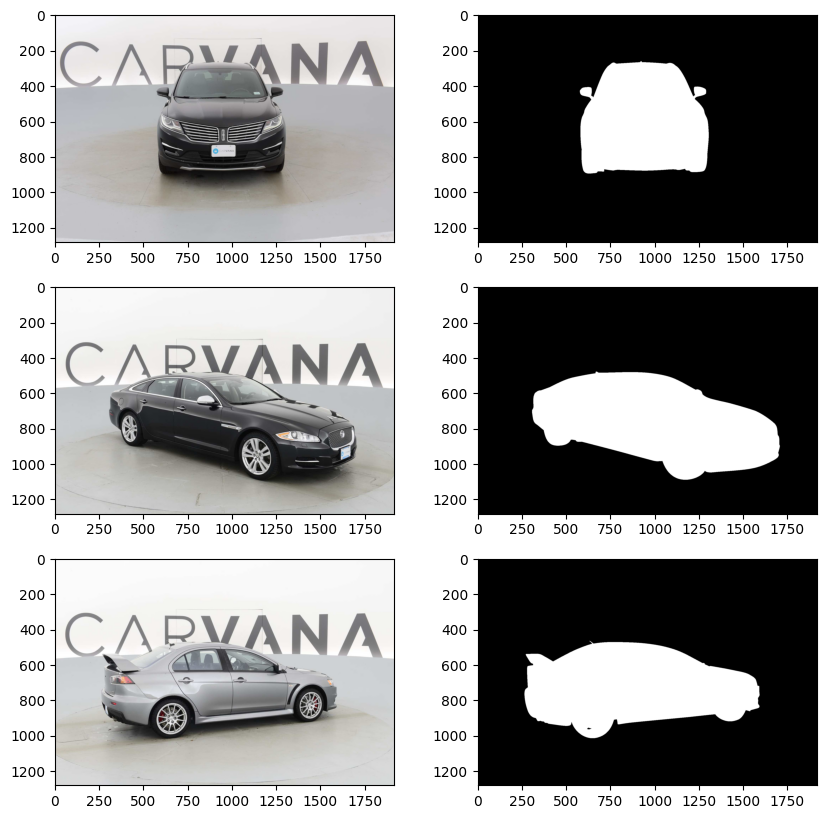

In [6]:
def create_file_list(root_dir, num_files=None):
    train_dir = root_dir/'train'
    mask_dir  = root_dir/'train_masks'
    
    all_files = []

    for img_fl in train_dir.glob('*.jpg'):
        pair = []
        mask_fl = img_fl.with_stem(img_fl.stem + '_mask').with_suffix('.gif')
        
        parts = list(mask_fl.parts)
        parts[-2] = 'train_masks'
        mask_fl = Path(*parts)
        
        # print(f'Image file : {img_fl}, Mask file : {mask_fl}')
        all_files.append((img_fl, mask_fl))

    random.shuffle(all_files)
        
    return all_files

## -- all_files are all the pair of files (image, mask --  
all_files = create_file_list(TRAIN_ROOT_DIR)

print(all_files[0][0])
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    for j in range(2):
        img = Image.open(all_files[i][j])
        axes[i][j].imshow(img)
plt.show()

  0%|          | 0/5088 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image file : bb2f95262773_01.jpg, Mask file : bb2f95262773_01_mask.gif
img.size : (240, 448, 3)
Image file : cd2e588ef1c5_15.jpg, Mask file : cd2e588ef1c5_15_mask.gif
img.size : (240, 448, 3)
Image file : 70b6a79565fe_12.jpg, Mask file : 70b6a79565fe_12_mask.gif
img.size : (240, 448, 3)


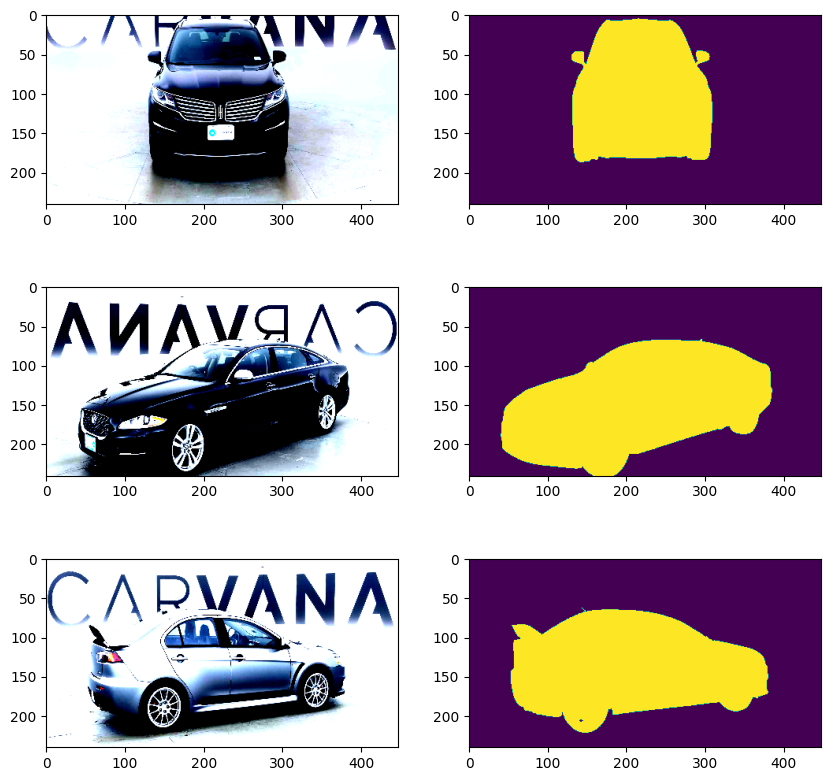

In [7]:
## Define transformations
def transform(image, mask, top, bottom, left, right):
    width, height = image.size
    
    transform = A.Compose([
        A.Crop(x_min=left, y_min=top, x_max=width - right, y_max=height - bottom),
        # A.Resize(height=960, width=1792),
        A.Resize(height=240, width=448),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],  # Mean for each channel for ImageNet dataset
            std=[0.229, 0.224, 0.225],  # Standard deviation for each channel for ImageNet dataset
            max_pixel_value=255.0,  # This is the default and assumes the input is in range [0, 255]
        )
        # A.ToTensorV2()
    ])
    
    transformed = transform(image=np.array(image), mask=np.array(mask))
    
    return transformed['image'], transformed['mask']

dataset_len = len(all_files)

# Save the processed files in *.npy format
def save_processed_files():
    for counter, (image_path, mask_path) in enumerate(tqdm(all_files)):
        # print(f'counter : {counter}, pair : {image, mask}')
        
        image = Image.open(image_path)
        mask  = Image.open(mask_path)

        image, mask = transform(image, mask, 250, 200, 50, 50)

        target_dir = 'train' if counter < int(dataset_len*0.7) else 'val'
        save_path = PROCESSED_IMAGES_DIR/target_dir

        image_save_path = save_path/'images'
        mask_save_path = save_path/'masks'
        
        image_save_path.mkdir(parents=True, exist_ok=True)
        mask_save_path.mkdir(parents=True, exist_ok=True)
        
        # print(f'Saving image {image} at : {image_save_path}')
        np.save(image_save_path/image_path.name.replace('jpg', 'npy'), image)
        
        # print(f'Saving mask {mask} at : {mask_save_path}')
        np.save(mask_save_path/mask_path.name.replace('gif', 'npy'), mask)

save_processed_files()  
        
ll = all_files[0:3]
# -------- TESTING PURPOSE ONLY -------------
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    image, mask = ll[i]
    
    print(f'Image file : {image.name}, Mask file : {mask.name}')
    
    image = Image.open(image)
    mask = Image.open(mask)
    image, mask = transform(image, mask, 250, 200, 50, 50)
    print(f'img.size : {image.shape}')
    axes[i][0].imshow(image)
    axes[i][1].imshow(mask)
plt.show()